In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../survey_ops/utils')
from ephemerides import get_source_ra_dec, equatorial_to_topographic, topographic_to_equatorial
from geometry import angular_separation
from units import *

sys.path.append('../survey_ops/src')
import environments
from offline_dataset import TelescopeDatasetv0
from agents import Agent
from algorithms import DDQN, BehaviorCloning
from offline_dataset import OfflineDataset

In [3]:
from pytorch_utils import seed_everything
seed_everything(10)

# Load and cut data from fits file, save as .json

In [4]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Instantiate the offline dataset choosing number of bins for (az,el)

## You can get the data/transitions for the entire dataset in the dataframe

In [5]:
num_bins_1d = 19

dataset = OfflineDataset(
    df, 
    num_bins_1d=num_bins_1d, 
    normalize_state=True,
) #specific_years=[2013,2014])

In [18]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

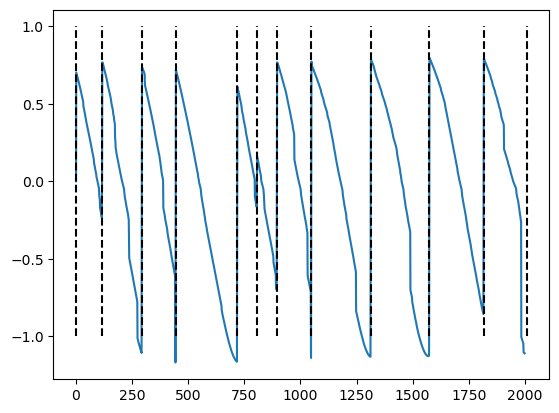

In [23]:
stop = 2000
plt.plot(dataset.sun_el[:stop])
plt.vlines(first_obs_in_night_indices[:12], ymin=-1., ymax=1., linestyle='--', color='black')

In [26]:
dataset._df.columns

Index(['expnum', 'ra', 'dec', 'exptime', 'filter', 'propid', 'program', 'teff',
       'fwhm', 'datetime', 'az', 'zd', 'ha', 'airmass', 'qc_fwhm', 'qc_cloud',
       'qc_sky', 'qc_teff', 'timestamp', 'night'],
      dtype='object')

In [27]:
T_obs = []
for day, subdf in dataset._groups:
    timestamps = subdf['timestamp'].values
    T_obs.append(timestamps[-1] - timestamps[0])


In [28]:
T_obs = np.array(T_obs)/60/60

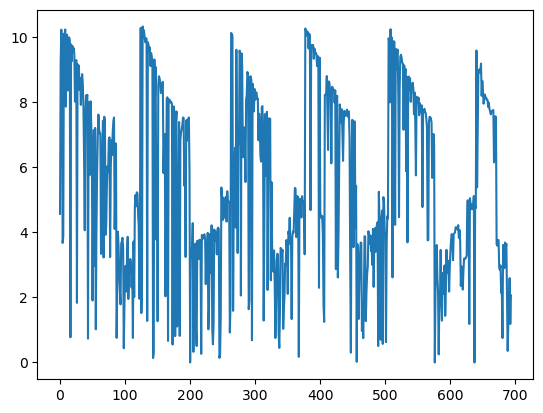

In [29]:
plt.plot(T_obs)

## You can also specify years, months, days, and filters to get a smaller subset of transitions

### First night of survey, all filters

In [111]:
num_bins_1d = 19
dataset = OfflineDataset(
    df, 
    num_bins_1d=19, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8],
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [110]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,229362,324.616028,-53.981499,90,r,2012B-0001,survey,0.76,0.86,2013-09-01 04:20:30,193.940002,24.790001,9.914000,1.10,0.86,0.39,2.94,0.76,1378009230,2013-08-31
112,229363,308.637512,-56.011250,90,i,2012B-0001,survey,1.24,0.84,2013-09-01 04:23:03,208.240005,31.809999,26.498501,1.18,0.84,0.23,6.89,1.24,1378009383,2013-08-31
113,229364,314.232361,-56.010166,90,r,2012B-0001,survey,0.57,0.87,2013-09-01 04:25:11,204.220001,29.870001,21.446125,1.15,0.87,0.48,3.21,0.57,1378009511,2013-08-31
114,229365,314.236420,-56.010414,90,i,2012B-0001,survey,1.10,0.82,2013-09-01 04:27:11,204.580002,30.020000,21.859875,1.15,0.82,0.32,6.94,1.10,1378009631,2013-08-31


# Configure model, data selection, and training setup

In [113]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [114]:
# num_bins_1d = 19
# dataset = OfflineDataset(
#     df, 
#     num_bins_1d=19, 
#     normalize_state=True,
#     specific_years=[2018],
#     specific_months=[12],
#     specific_days=np.arange(2),
#     specific_filters=['g']
# )

In [115]:
batch_size = 32
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [116]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 5e-3,
    'loss_fxn': None, #torch.nn.cross_entropy,
    # 'use_double': True,
}
alg = BehaviorCloning(**alg_config)

fit_config = {
    'num_epochs' : 100,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Visualize dataset in (az, el) and binning sizes

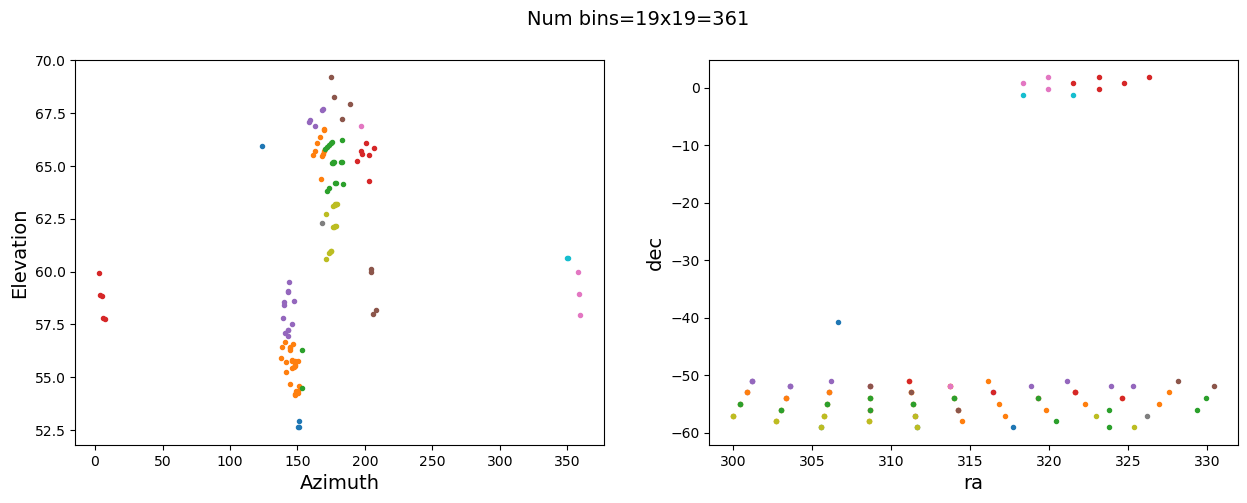

In [117]:
s = 1000/len(dataset)
fig, axs = plt.subplots(1,2, figsize=(15,5))
for bin_id in dataset.id2azel.keys():
    field_ids = np.array(dataset.id2azel[bin_id])
    axs[0].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[0].set_xlabel('Azimuth', fontsize=14)
axs[0].set_ylabel('Elevation', fontsize=14)

for bin_id in dataset.id2radec.keys():
    field_ids = np.array(dataset.id2radec[bin_id])
    axs[1].scatter(field_ids[:, 0], field_ids[:, 1], label='bin' + str(bin_id), s=s)
axs[1].set_xlabel('ra', fontsize=14)
axs[1].set_ylabel('dec', fontsize=14)

fig.suptitle(f'Num bins={num_bins_1d}x{num_bins_1d}={dataset.num_actions}', fontsize=14)
fig.savefig(fig_outdir + 'plot_observations_in_sky_colored_bins.png')

# Train

In [118]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                                 | 0/11600 [00:00<?, ?it/s]/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/algorithms.py:163: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  expert_actions = torch.tensor(expert_actions, device=self.device, dtype=torch.long) # needs to be long for .gather()
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_obs = torch.tensor(eval_obs, device=self.device)
/home/rachel/Projects/survey-ops/notebooks/../survey_ops/src/agents.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clon

Train step 0: Accuracy = 0.062, Loss = 5.9294


  1%|▌                                     | 159/11600 [00:00<00:31, 363.10it/s]

Train step 100: Accuracy = 0.500, Loss = 0.8926


  2%|▊                                     | 243/11600 [00:00<00:29, 389.80it/s]

Train step 200: Accuracy = 0.688, Loss = 1.0592


  3%|█▏                                    | 365/11600 [00:01<00:28, 392.08it/s]

Train step 300: Accuracy = 0.531, Loss = 0.9195


  4%|█▍                                    | 448/11600 [00:01<00:27, 402.12it/s]

Train step 400: Accuracy = 0.750, Loss = 0.7475


  5%|█▉                                    | 574/11600 [00:01<00:26, 409.72it/s]

Train step 500: Accuracy = 0.625, Loss = 0.7737


  6%|██▏                                   | 657/11600 [00:01<00:26, 411.21it/s]

Train step 600: Accuracy = 0.531, Loss = 0.7404


  7%|██▌                                   | 783/11600 [00:02<00:26, 414.10it/s]

Train step 700: Accuracy = 0.812, Loss = 0.7465


  7%|██▊                                   | 867/11600 [00:02<00:25, 414.10it/s]

Train step 800: Accuracy = 0.688, Loss = 0.4344


  8%|███                                   | 951/11600 [00:02<00:25, 411.22it/s]

Train step 900: Accuracy = 0.719, Loss = 0.6322


  9%|███▍                                 | 1076/11600 [00:02<00:25, 409.09it/s]

Train step 1000: Accuracy = 0.812, Loss = 0.4516


 10%|███▋                                 | 1158/11600 [00:02<00:25, 405.10it/s]

Train step 1100: Accuracy = 0.844, Loss = 0.4264


 11%|████                                 | 1281/11600 [00:03<00:25, 402.30it/s]

Train step 1200: Accuracy = 0.875, Loss = 0.5268


 12%|████▎                                | 1364/11600 [00:03<00:25, 405.51it/s]

Train step 1300: Accuracy = 0.844, Loss = 0.6197


 12%|████▌                                | 1447/11600 [00:03<00:25, 405.77it/s]

Train step 1400: Accuracy = 0.844, Loss = 0.4113


 14%|█████                                | 1573/11600 [00:03<00:24, 407.47it/s]

Train step 1500: Accuracy = 0.812, Loss = 0.3988


 14%|█████▎                               | 1656/11600 [00:04<00:24, 404.46it/s]

Train step 1600: Accuracy = 0.781, Loss = 0.3803


 15%|█████▋                               | 1779/11600 [00:04<00:24, 396.95it/s]

Train step 1700: Accuracy = 0.844, Loss = 0.1410


 16%|█████▉                               | 1860/11600 [00:04<00:24, 393.91it/s]

Train step 1800: Accuracy = 0.969, Loss = 0.3526


 17%|██████▏                              | 1940/11600 [00:04<00:24, 388.16it/s]

Train step 1900: Accuracy = 0.906, Loss = 0.2209


 18%|██████▌                              | 2058/11600 [00:05<00:24, 385.15it/s]

Train step 2000: Accuracy = 0.906, Loss = 0.1827


 19%|██████▉                              | 2177/11600 [00:05<00:24, 386.32it/s]

Train step 2100: Accuracy = 0.938, Loss = 0.2181


 19%|███████▏                             | 2256/11600 [00:05<00:23, 389.59it/s]

Train step 2200: Accuracy = 0.750, Loss = 0.1636


 20%|███████▌                             | 2376/11600 [00:06<00:23, 392.24it/s]

Train step 2300: Accuracy = 0.906, Loss = 0.1702


 21%|███████▊                             | 2457/11600 [00:06<00:23, 393.05it/s]

Train step 2400: Accuracy = 0.938, Loss = 0.1465


 22%|████████▏                            | 2577/11600 [00:06<00:22, 393.55it/s]

Train step 2500: Accuracy = 0.969, Loss = 0.0459


 23%|████████▍                            | 2657/11600 [00:06<00:22, 388.96it/s]

Train step 2600: Accuracy = 0.906, Loss = 0.2045


 24%|████████▊                            | 2775/11600 [00:07<00:22, 386.28it/s]

Train step 2700: Accuracy = 0.875, Loss = 0.0681


 25%|█████████                            | 2855/11600 [00:07<00:22, 392.69it/s]

Train step 2800: Accuracy = 0.906, Loss = 0.0790


 26%|█████████▍                           | 2976/11600 [00:07<00:21, 393.86it/s]

Train step 2900: Accuracy = 0.969, Loss = 0.2011


 26%|█████████▋                           | 3056/11600 [00:07<00:22, 385.79it/s]

Train step 3000: Accuracy = 0.875, Loss = 0.1183


 27%|██████████                           | 3173/11600 [00:08<00:22, 379.94it/s]

Train step 3100: Accuracy = 0.938, Loss = 0.0797


 28%|██████████▎                          | 3250/11600 [00:08<00:22, 377.34it/s]

Train step 3200: Accuracy = 1.000, Loss = 0.1102


 29%|██████████▋                          | 3367/11600 [00:08<00:21, 386.04it/s]

Train step 3300: Accuracy = 1.000, Loss = 0.2466


 30%|██████████▉                          | 3447/11600 [00:08<00:20, 388.97it/s]

Train step 3400: Accuracy = 1.000, Loss = 0.1438


 31%|███████████▍                         | 3569/11600 [00:09<00:20, 388.30it/s]

Train step 3500: Accuracy = 0.875, Loss = 0.1733


 31%|███████████▋                         | 3649/11600 [00:09<00:20, 390.96it/s]

Train step 3600: Accuracy = 0.875, Loss = 0.1109


 32%|████████████                         | 3769/11600 [00:09<00:20, 387.10it/s]

Train step 3700: Accuracy = 0.969, Loss = 0.1057


 33%|████████████▎                        | 3847/11600 [00:09<00:20, 380.57it/s]

Train step 3800: Accuracy = 0.812, Loss = 0.2321


 34%|████████████▋                        | 3967/11600 [00:10<00:19, 389.40it/s]

Train step 3900: Accuracy = 1.000, Loss = 0.1981


 35%|████████████▉                        | 4045/11600 [00:10<00:19, 384.37it/s]

Train step 4000: Accuracy = 0.938, Loss = 0.0924


 36%|█████████████▎                       | 4164/11600 [00:10<00:19, 390.49it/s]

Train step 4100: Accuracy = 0.938, Loss = 0.0964


 37%|█████████████▌                       | 4244/11600 [00:10<00:18, 390.37it/s]

Train step 4200: Accuracy = 0.938, Loss = 0.0829


 38%|█████████████▉                       | 4363/11600 [00:11<00:18, 385.03it/s]

Train step 4300: Accuracy = 0.938, Loss = 0.0962


 38%|██████████████▏                      | 4441/11600 [00:11<00:18, 383.44it/s]

Train step 4400: Accuracy = 0.938, Loss = 0.1941


 39%|██████████████▌                      | 4560/11600 [00:11<00:18, 389.41it/s]

Train step 4500: Accuracy = 1.000, Loss = 0.1280


 40%|██████████████▉                      | 4678/11600 [00:12<00:17, 388.23it/s]

Train step 4600: Accuracy = 0.906, Loss = 0.0891


 41%|███████████████▏                     | 4756/11600 [00:12<00:18, 380.18it/s]

Train step 4700: Accuracy = 0.969, Loss = 0.1756


 42%|███████████████▌                     | 4873/11600 [00:12<00:17, 379.28it/s]

Train step 4800: Accuracy = 0.969, Loss = 0.1068


 43%|███████████████▊                     | 4951/11600 [00:12<00:17, 383.03it/s]

Train step 4900: Accuracy = 1.000, Loss = 0.0652


 44%|████████████████▏                    | 5068/11600 [00:13<00:18, 357.10it/s]

Train step 5000: Accuracy = 0.969, Loss = 0.3215


 44%|████████████████▍                    | 5143/11600 [00:13<00:17, 365.12it/s]

Train step 5100: Accuracy = 0.938, Loss = 0.0342


 45%|████████████████▊                    | 5262/11600 [00:13<00:16, 382.40it/s]

Train step 5200: Accuracy = 1.000, Loss = 0.0358


 46%|█████████████████                    | 5340/11600 [00:13<00:16, 379.20it/s]

Train step 5300: Accuracy = 0.969, Loss = 0.1441


 47%|█████████████████▍                   | 5459/11600 [00:14<00:16, 383.44it/s]

Train step 5400: Accuracy = 1.000, Loss = 0.0463


 48%|█████████████████▊                   | 5578/11600 [00:14<00:15, 388.68it/s]

Train step 5500: Accuracy = 0.969, Loss = 0.0799


 49%|██████████████████                   | 5658/11600 [00:14<00:15, 391.32it/s]

Train step 5600: Accuracy = 1.000, Loss = 0.0800


 49%|██████████████████▎                  | 5738/11600 [00:14<00:15, 380.06it/s]

Train step 5700: Accuracy = 0.969, Loss = 0.1533


 50%|██████████████████▋                  | 5856/11600 [00:15<00:17, 336.21it/s]

Train step 5800: Accuracy = 1.000, Loss = 0.0217


 51%|███████████████████                  | 5971/11600 [00:15<00:15, 366.96it/s]

Train step 5900: Accuracy = 1.000, Loss = 0.0553


 52%|███████████████████▎                 | 6050/11600 [00:15<00:14, 378.70it/s]

Train step 6000: Accuracy = 0.688, Loss = 0.5708


 53%|███████████████████▋                 | 6167/11600 [00:16<00:14, 377.87it/s]

Train step 6100: Accuracy = 0.938, Loss = 0.4214


 54%|███████████████████▉                 | 6246/11600 [00:16<00:13, 385.23it/s]

Train step 6200: Accuracy = 0.938, Loss = 0.0263


 55%|████████████████████▎                | 6364/11600 [00:16<00:13, 389.58it/s]

Train step 6300: Accuracy = 0.969, Loss = 0.0866


 56%|████████████████████▌                | 6442/11600 [00:16<00:13, 384.38it/s]

Train step 6400: Accuracy = 1.000, Loss = 0.0846


 57%|████████████████████▉                | 6558/11600 [00:17<00:13, 376.89it/s]

Train step 6500: Accuracy = 1.000, Loss = 0.0282


 58%|█████████████████████▎               | 6673/11600 [00:17<00:13, 378.97it/s]

Train step 6600: Accuracy = 0.969, Loss = 0.0833


 58%|█████████████████████▌               | 6751/11600 [00:17<00:12, 382.70it/s]

Train step 6700: Accuracy = 1.000, Loss = 0.0862


 59%|█████████████████████▉               | 6870/11600 [00:17<00:12, 388.25it/s]

Train step 6800: Accuracy = 0.969, Loss = 0.0092


 60%|██████████████████████▏              | 6949/11600 [00:18<00:11, 389.17it/s]

Train step 6900: Accuracy = 1.000, Loss = 0.0556


 61%|██████████████████████▌              | 7069/11600 [00:18<00:11, 390.86it/s]

Train step 7000: Accuracy = 0.938, Loss = 0.0648


 62%|██████████████████████▊              | 7149/11600 [00:18<00:11, 389.35it/s]

Train step 7100: Accuracy = 1.000, Loss = 0.0254


 63%|███████████████████████▏             | 7268/11600 [00:18<00:11, 384.04it/s]

Train step 7200: Accuracy = 0.969, Loss = 0.0462


 63%|███████████████████████▍             | 7347/11600 [00:19<00:11, 378.82it/s]

Train step 7300: Accuracy = 1.000, Loss = 0.0283


 64%|███████████████████████▊             | 7468/11600 [00:19<00:10, 391.46it/s]

Train step 7400: Accuracy = 1.000, Loss = 0.0274


 65%|████████████████████████             | 7549/11600 [00:19<00:10, 390.24it/s]

Train step 7500: Accuracy = 0.969, Loss = 0.0966


 66%|████████████████████████▍            | 7669/11600 [00:19<00:10, 391.41it/s]

Train step 7600: Accuracy = 1.000, Loss = 0.0398


 67%|████████████████████████▋            | 7748/11600 [00:20<00:10, 383.41it/s]

Train step 7700: Accuracy = 1.000, Loss = 0.0218


 68%|█████████████████████████            | 7867/11600 [00:20<00:09, 386.98it/s]

Train step 7800: Accuracy = 1.000, Loss = 0.0190


 68%|█████████████████████████▎           | 7946/11600 [00:20<00:09, 389.02it/s]

Train step 7900: Accuracy = 1.000, Loss = 0.0366


 70%|█████████████████████████▋           | 8064/11600 [00:20<00:09, 390.06it/s]

Train step 8000: Accuracy = 1.000, Loss = 0.0123


 70%|█████████████████████████▉           | 8144/11600 [00:21<00:08, 385.06it/s]

Train step 8100: Accuracy = 1.000, Loss = 0.0078


 71%|██████████████████████████▎          | 8262/11600 [00:21<00:08, 386.30it/s]

Train step 8200: Accuracy = 1.000, Loss = 0.0074


 72%|██████████████████████████▌          | 8339/11600 [00:21<00:08, 375.30it/s]

Train step 8300: Accuracy = 1.000, Loss = 0.0074


 73%|██████████████████████████▉          | 8457/11600 [00:21<00:08, 385.27it/s]

Train step 8400: Accuracy = 1.000, Loss = 0.0155


 74%|███████████████████████████▎         | 8574/11600 [00:22<00:07, 378.61it/s]

Train step 8500: Accuracy = 1.000, Loss = 0.0158


 75%|███████████████████████████▌         | 8653/11600 [00:22<00:07, 384.89it/s]

Train step 8600: Accuracy = 1.000, Loss = 0.0111


 76%|███████████████████████████▉         | 8773/11600 [00:22<00:07, 391.88it/s]

Train step 8700: Accuracy = 0.969, Loss = 0.0193


 76%|████████████████████████████▏        | 8852/11600 [00:23<00:07, 377.21it/s]

Train step 8800: Accuracy = 0.812, Loss = 1.0502


 77%|████████████████████████████▌        | 8968/11600 [00:23<00:06, 376.20it/s]

Train step 8900: Accuracy = 0.969, Loss = 0.0273


 78%|████████████████████████████▊        | 9046/11600 [00:23<00:06, 383.67it/s]

Train step 9000: Accuracy = 1.000, Loss = 0.0662


 79%|█████████████████████████████▏       | 9165/11600 [00:23<00:06, 387.02it/s]

Train step 9100: Accuracy = 0.938, Loss = 0.0241


 80%|█████████████████████████████▍       | 9243/11600 [00:24<00:06, 382.62it/s]

Train step 9200: Accuracy = 0.969, Loss = 0.0350


 81%|█████████████████████████████▊       | 9360/11600 [00:24<00:06, 357.39it/s]

Train step 9300: Accuracy = 1.000, Loss = 0.0034


 82%|██████████████████████████████▏      | 9473/11600 [00:24<00:06, 350.41it/s]

Train step 9400: Accuracy = 0.969, Loss = 0.0975


 82%|██████████████████████████████▍      | 9548/11600 [00:24<00:05, 362.23it/s]

Train step 9500: Accuracy = 0.969, Loss = 0.0258


 83%|██████████████████████████████▊      | 9665/11600 [00:25<00:05, 380.72it/s]

Train step 9600: Accuracy = 1.000, Loss = 0.0078


 84%|███████████████████████████████      | 9743/11600 [00:25<00:05, 364.84it/s]

Train step 9700: Accuracy = 0.906, Loss = 0.3001


 85%|███████████████████████████████▍     | 9850/11600 [00:25<00:05, 337.16it/s]

Train step 9800: Accuracy = 0.906, Loss = 0.4672


 86%|███████████████████████████████▊     | 9968/11600 [00:26<00:04, 370.87it/s]

Train step 9900: Accuracy = 0.875, Loss = 0.1265


 87%|███████████████████████████████▏    | 10044/11600 [00:26<00:04, 366.60it/s]

Train step 10000: Accuracy = 0.969, Loss = 0.0113


 88%|███████████████████████████████▌    | 10156/11600 [00:26<00:04, 357.24it/s]

Train step 10100: Accuracy = 0.938, Loss = 0.0506


 89%|███████████████████████████████▉    | 10273/11600 [00:26<00:03, 375.91it/s]

Train step 10200: Accuracy = 1.000, Loss = 0.0051


 89%|████████████████████████████████    | 10350/11600 [00:27<00:03, 370.39it/s]

Train step 10300: Accuracy = 0.969, Loss = 0.0248


 90%|████████████████████████████████▍   | 10464/11600 [00:27<00:03, 368.56it/s]

Train step 10400: Accuracy = 1.000, Loss = 0.0160


 91%|████████████████████████████████▋   | 10540/11600 [00:27<00:02, 369.10it/s]

Train step 10500: Accuracy = 0.938, Loss = 0.0841


 92%|█████████████████████████████████   | 10654/11600 [00:27<00:02, 371.33it/s]

Train step 10600: Accuracy = 0.969, Loss = 0.0267


 93%|█████████████████████████████████▍  | 10774/11600 [00:28<00:02, 388.76it/s]

Train step 10700: Accuracy = 0.969, Loss = 0.0802


 94%|█████████████████████████████████▋  | 10853/11600 [00:28<00:01, 386.78it/s]

Train step 10800: Accuracy = 0.969, Loss = 0.1842


 95%|██████████████████████████████████  | 10971/11600 [00:28<00:01, 375.16it/s]

Train step 10900: Accuracy = 1.000, Loss = 0.0331


 95%|██████████████████████████████████▎ | 11048/11600 [00:28<00:01, 376.87it/s]

Train step 11000: Accuracy = 1.000, Loss = 0.0103


 96%|██████████████████████████████████▋ | 11165/11600 [00:29<00:01, 384.84it/s]

Train step 11100: Accuracy = 1.000, Loss = 0.0403


 97%|██████████████████████████████████▉ | 11244/11600 [00:29<00:00, 386.51it/s]

Train step 11200: Accuracy = 1.000, Loss = 0.0110


 98%|███████████████████████████████████▎| 11361/11600 [00:29<00:00, 386.76it/s]

Train step 11300: Accuracy = 1.000, Loss = 0.0369


 99%|███████████████████████████████████▌| 11479/11600 [00:30<00:00, 385.70it/s]

Train step 11400: Accuracy = 1.000, Loss = 0.0049


100%|███████████████████████████████████▊| 11558/11600 [00:30<00:00, 389.33it/s]

Train step 11500: Accuracy = 1.000, Loss = 0.0672


100%|████████████████████████████████████| 11600/11600 [00:30<00:00, 381.24it/s]

Total train time = 30.548807621002197s


In [119]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

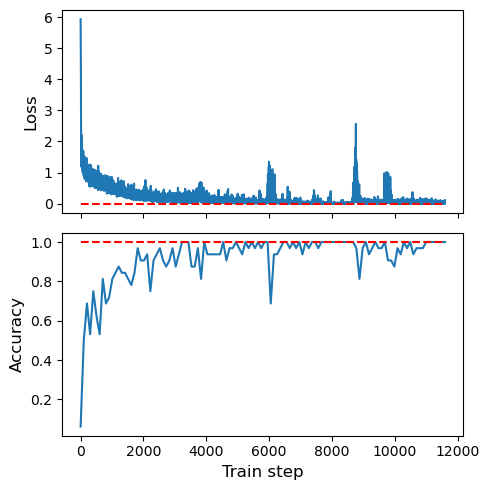

In [120]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=12)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=12)
axs[1].set_ylabel('Accuracy', fontsize=12)
axs[1].set_xlabel('Train step', fontsize=12)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

# Evaluate

In [121]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.41,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.60,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.62,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.52,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.44,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,229362,324.616028,-53.981499,90,r,2012B-0001,survey,0.76,0.86,2013-09-01 04:20:30,193.940002,24.790001,9.914000,1.10,0.86,0.39,2.94,0.76,1378009230,2013-08-31
112,229363,308.637512,-56.011250,90,i,2012B-0001,survey,1.24,0.84,2013-09-01 04:23:03,208.240005,31.809999,26.498501,1.18,0.84,0.23,6.89,1.24,1378009383,2013-08-31
113,229364,314.232361,-56.010166,90,r,2012B-0001,survey,0.57,0.87,2013-09-01 04:25:11,204.220001,29.870001,21.446125,1.15,0.87,0.48,3.21,0.57,1378009511,2013-08-31
114,229365,314.236420,-56.010414,90,i,2012B-0001,survey,1.10,0.82,2013-09-01 04:27:11,204.580002,30.020000,21.859875,1.15,0.82,0.32,6.94,1.10,1378009631,2013-08-31


In [ ]:
from environments import OfflineEnv

env_name = 'OfflineEnv'

gym.register(
    id=f"gymnasium_env/{env_name}",
    entry_point=OfflineEnv,
    max_episode_steps=300,  # Prevent infinite episodes. Here just set to 300 even though episode will terminate when stepping to last element of sequence
)

# for eval step only
env_config = {
    'id': f"gymnasium_env/{env_name}",
    'dataset': dataset
}


env = gym.make(**env_config)
from gymnasium.utils.env_checker import check_env

# This will catch many common issues
try:
    check_env(env.unwrapped)
    print("Environment passes all checks!")
except Exception as e:
    print(f"Environment has issues: {e}")

In [22]:
agent.evaluate(env=env, num_episodes=1)
with open(outdir + 'eval_metrics.pkl', 'rb') as handle:
    eval_metrics = pickle.load(handle)

100%|██████████| 1/1 [00:00<00:00, 90.72it/s]

terminated at 58
eval_metrics.pkl saved in ../results/None/


/tmp/ipykernel_17254/76053858.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


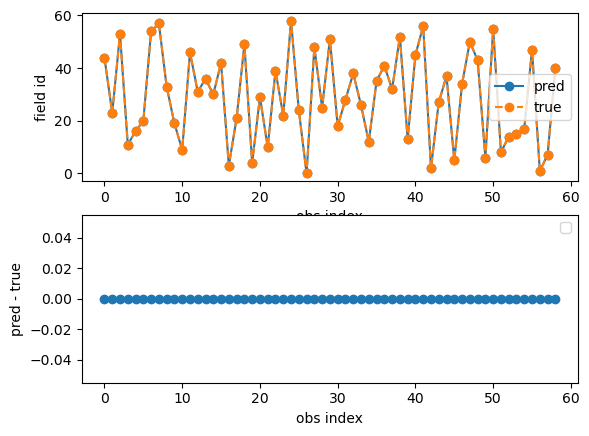

In [23]:
target_sequence = dataset._schedule_field_ids[0]
eval_sequence = eval_metrics['observations']['ep-0'][:, 0]

fig, axs = plt.subplots(2)
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true')
axs[0].legend()
axs[0].set_xlabel('obs index')
axs[0].set_ylabel('field id')

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')


fig.savefig(outdir + 'learned_sequence.png')